<a href="https://colab.research.google.com/github/veselm73/BP/blob/main/SDUEBA_010_diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r https://raw.githubusercontent.com/veselm73/BP/main/requirements_SDUEBA010.txt
!git clone https://github.com/uef-machine-learning/tspgclu.git
%cd tspgclu
!pip install -r requirements.txt
!pip install .

fatal: destination path 'tspgclu' already exists and is not an empty directory.
/content/tspgclu
Processing /content/tspgclu
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for tspg: filename=tspg-1.0-cp311-cp311-linux_x86_64.whl size=536186 sha256=0d4774621e1245d1e1d7adab921b6e324ea2f7aef74609994f1243fcd7131716
  Stored in directory: /tmp/pip-ephem-wheel-cache-45coshrr/wheels/76/b6/67/20b88094c0a7504d3e162a7729d9ab59dad6b547bc230d033f
Successfully built tspg
  Attempting uninstall: tspg
    Found existing installation: tspg 1.0
    Uninstalling tspg-1.0:
      Successfully uninstalled tspg-1.0


In [2]:
# Dependencies
import os
import re
import string
import numpy as np
import pandas as pd
import scipy
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sklearn
from sklearn.preprocessing import normalize, LabelEncoder, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import torch
from transformers import AutoTokenizer, AutoModel
from ucimlrepo import fetch_ucirepo
from gensim.models import Word2Vec
import tspg
import umap.umap_ as umap

/usr/local/lib/python3.11/dist-packages/umap/__init__.py:36: UserWarning: Module tspg was already imported from /usr/local/lib/python3.11/dist-packages/tspg.cpython-311-x86_64-linux-gnu.so, but /content/tspgclu is being added to sys.path
  import pkg_resources


In [3]:
#SDUEBA Parameters:
"""
vector_space_dimension  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
"""
frac_of_dataset = 0.5
n_features = 30

#Embeddings parameters:
embedding_method = "bert"
vector_space_dimension = 100
descriptive_format = True
weighted_embeddings = True
use_bias = True
alpha_weight = 0

#Clustering parameters
clustering_method = "tspg"      #"agglomerative"/"spherical_kmeans"/"tspg"/"hdbscan"
#One of these two has to be None, for kmeans dendogram_cut = None
n_clusters = 35
dendrogram_cut = None #0.000012




max_depth = 3
test_size = 0.2
tree_accuracy_threshold = 0.95
target_column = 'readmit_binary'
target_value = 'Yes'

#Quality metric parameters
description_length_limit = 3
difference_limit = 0
subgroup_size_limit = 100


In [4]:
#Best feature selection
def create_shorter_sample(df, frac=None):
    df_sampled = df.sample(frac=frac, random_state=73)
    df_sampled = df_sampled.reset_index(drop=True)
    return df_sampled

def normalize_weights(weights):
    weights_array = np.array(weights)
    min_val = np.min(weights_array)
    max_val = np.max(weights_array)

    if max_val == min_val:
      return np.zeros_like(weights_array)

    normalized_weights = (weights_array - min_val) / (max_val - min_val)
    return normalized_weights

file_path = "https://kmlinux.fjfi.cvut.cz/~veselm73/diabetes_preprocessed.csv"

df = create_shorter_sample(pd.read_csv(file_path), frac=frac_of_dataset)
df = df.drop(columns=['readmitted', 'readmit_30_days'])
df_encoded = df.copy()
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

imputer = SimpleImputer(strategy="most_frequent")
df_imputed = pd.DataFrame(imputer.fit_transform(df_encoded), columns=df_encoded.columns)

X = df_imputed.drop(columns=["readmit_binary"])
y = df_imputed["readmit_binary"]

model = RandomForestClassifier(n_estimators=100, random_state=73)
model.fit(X, y)

feature_weights = pd.DataFrame({'Feature': X.columns, 'Weight': normalize_weights(model.feature_importances_)})
feature_weights = pd.concat([feature_weights, pd.DataFrame({'Feature': [target_column], 'Weight': [1]})], ignore_index=True)
feature_weights.head(30)

<ipython-input-4-76957f4f9aaf>:20: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = create_shorter_sample(pd.read_csv(file_path), frac=frac_of_dataset)


,Feature,Weight
0,race,0.253934
1,gender,0.205576
2,age,0.534778
3,weight,0.067189
4,admission_type_id,0.195217
5,discharge_disposition_id,0.340367
6,admission_source_id,0.160367
7,time_in_hospital,0.627665
8,payer_code,0.444085
9,medical_specialty,0.451934


In [5]:
#Data augemntation
def create_quantile_categorical_feature(df, feature_name):

    if feature_name not in df.columns:
        print(f"Error: Feature '{feature_name}' not found in DataFrame.")
        return df

    num_quantiles = 5
    quantiles = np.linspace(0, 1, num_quantiles + 1)
    bins = df[feature_name].quantile(quantiles).tolist()
    bins[-1] = float('inf')

    bins = sorted(list(set(bins)))

    labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

    if len(bins) - 1 < 5:
        labels = labels[:len(bins) - 1]

    df[f'{feature_name}_category'] = pd.cut(df[feature_name], bins=bins, labels=labels, include_lowest=True, duplicates='drop')
    df = df.drop(columns=[feature_name])

    return df

top_features = feature_weights.sort_values(by='Weight', ascending=False).head(n_features)['Feature']
features_raw = df[top_features]
features_raw = features_raw.drop(columns=[target_column])

target_df = df[['readmit_binary']].copy()
target_df['readmit_binary'] = target_df['readmit_binary'].astype(str).replace({'True': 'Yes', 'False': 'No'})



for column in ['num_lab_procedures', 'num_medications', 'time_in_hospital', 'number_diagnoses', 'num_procedures', 'number_inpatient', 'number_outpatient', 'number_emergency']:
    features_raw = create_quantile_categorical_feature(features_raw, column)


features_raw.head()

Error: Feature 'number_emergency' not found in DataFrame.


,primary_diag_desc,diag_2_desc,diag_3_desc,age,medical_specialty,payer_code,discharge_disposition,discharge_disposition_id,insulin,race,...,change,glyburide,diabetesMed,num_lab_procedures_category,num_medications_category,time_in_hospital_category,number_diagnoses_category,num_procedures_category,number_inpatient_category,number_outpatient_category
0,"Depressive disorder, not elsewhere classified",Diabetes mellitus without mention of complicat...,"Extrinsic asthma, unspecified",[80-90),NaN,NaN,Discharged to home,1,No,Caucasian,...,No,Steady,Yes,High,Medium,Very High,Medium,Very Low,Very Low,Very Low
1,Malignant neoplasm of trachea,Secondary malignant neoplasm of kidney,Secondary malignant neoplasm of lung,[60-70),Emergency/Trauma,MC,Discharged/transferred to SNF,3,No,Caucasian,...,No,No,No,High,Medium,High,Medium,Low,Very Low,Very Low
2,Postinflammatory pulmonary fibrosis,"Acute gastritis, without mention of hemorrhage",Internal hemorrhoids without mention of compli...,[50-60),Family/GeneralPractice,NaN,Discharged/transferred to home with home healt...,6,Down,AfricanAmerican,...,Ch,No,Yes,Very Low,Very High,High,Medium,Medium,Very Low,Very Low
3,Coronary atherosclerosis of unspecified type o...,Diabetes mellitus without mention of complicat...,Malignant essential hypertension,[50-60),Cardiology,MC,Discharged to home,1,Steady,AfricanAmerican,...,No,No,Yes,Medium,Medium,Low,Very Low,Medium,Very Low,Very Low
4,"Diabetes with hyperosmolarity, type II or unsp...","Chronic airway obstruction, not elsewhere clas...",Need for prophylactic vaccination and inoculat...,[50-60),NaN,NaN,Discharged/transferred to SNF,3,Up,Caucasian,...,Ch,No,Yes,Very High,Very High,Low,Medium,Very Low,Very Low,Very Low


In [6]:
# Sentence creation
training_df = pd.merge(features_raw, target_df, left_index=True, right_index=True).astype(str)
class SentenceFormatter:
    def __init__(self, dataframe, descriptive_format=True):

        self.df = dataframe.copy()
        self.descriptive_format = descriptive_format

    def _prettify_column_names(self):

        return [' '.join(col.split('_')) for col in self.df.columns]

    def generate_sentences(self):

        sentences = []
        if self.descriptive_format:
            pretty_columns = self._prettify_column_names()
            for _, row in self.df.iterrows():
                sentence = [f"{col_name} is {val}" for col_name, val in zip(pretty_columns, row)]
                sentences.append(sentence)
        else:
            for _, row in self.df.iterrows():
                sentence = [str(val) for val in row]
                sentences.append(sentence)

        return sentences

formatter = SentenceFormatter(training_df, descriptive_format=descriptive_format)
sentences = formatter.generate_sentences()
print(sentences[0])

['primary diag desc is Depressive disorder, not elsewhere classified', 'diag 2 desc is Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled', 'diag 3 desc is Extrinsic asthma, unspecified', 'age is [80-90)', 'medical specialty is nan', 'payer code is nan', 'discharge disposition is Discharged to home', 'discharge disposition id is 1', 'insulin is No', 'race is Caucasian', 'had inpatient days is True', 'A1Cresult is None', 'gender is Female', 'admission type is Urgent', 'admission type id is 2', 'admission source is  Emergency Room', 'metformin is No', 'admission source id is 7', 'glipizide is No', 'change is No', 'glyburide is Steady', 'diabetesMed is Yes', 'num lab procedures category is High', 'num medications category is Medium', 'time in hospital category is Very High', 'number diagnoses category is Medium', 'num procedures category is Very Low', 'number inpatient category is Very Low', 'number outpatient category is Very Low', 

In [7]:
#Word2Vec/Bert training and clustering
#https://journalofbigdata.springeropen.com/articles/10.1186/s40537-024-01053-x

def clear_cuda_cache():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

class Word2VecModel:
    def __init__(self, sentences, vector_size=36, window=5, min_count=1):
        self.model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count)

    def get_embedding(self, sentence, weighted_embeddings=False, feature_weights=None):
        word_embeddings = [self.model.wv[word] for word in sentence if word in self.model.wv]
        if not word_embeddings:
            return np.zeros(self.model.vector_size)

        if weighted_embeddings and feature_weights is not None:
            weights = np.array(feature_weights['Weight'].tolist())
            return np.average(word_embeddings, axis=0, weights=weights)
        return np.mean(word_embeddings, axis=0)

class BertEmbedder:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2", device=None, batch_size=16):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(self.device).half()
        self.batch_size = batch_size

    def get_embedding(self, sentences):
        if isinstance(sentences[0], list):
            sentences = [" ".join(sentence) for sentence in sentences]

        embeddings = []
        for i in range(0, len(sentences), self.batch_size):
            batch = sentences[i:i + self.batch_size]
            inputs = self.tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=256).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

        return np.vstack(embeddings)

class SentenceEmbedder:
    def __init__(self, method="word2vec", **kwargs):
        self.method = method.lower()

        if self.method == "word2vec":
            self.model = Word2VecModel(**kwargs)
        elif self.method == "bert":
            self.model = BertEmbedder(**kwargs)
        else:
            raise ValueError("Unsupported embedding method. Use 'word2vec' or 'bert'.")

    def generate_embeddings(self, sentences, normalize=False, weighted_embeddings=False, feature_weights=None):
        if self.method == "word2vec":
            embeddings = np.array([
                self.model.get_embedding(s, weighted_embeddings=weighted_embeddings, feature_weights=feature_weights)
                for s in sentences
            ])
        elif self.method == "bert":
            embeddings = self.model.get_embedding(sentences)
        else:
            raise ValueError("Unsupported embedding method.")

        if normalize:
            norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
            norms[norms == 0] = 1  # Avoid division by zero
            embeddings = embeddings / norms

        return embeddings

class BiasedEmbedder:
    def __init__(self, alpha=0.1, random_state=73):
        self.alpha = alpha
        self.random_state = random_state

    def perpendicular_bias_embeddings(self, embeddings, targets):
        embeddings_biased = np.copy(embeddings)
        unique_classes, targets_encoded = np.unique(targets, return_inverse=True)
        np.random.seed(self.random_state)

        if len(unique_classes) > embeddings.shape[1]:
            raise ValueError("Number of unique classes exceeds embedding dimension, cannot create perpendicular biases.")

        bias_vectors = np.eye(len(unique_classes), embeddings.shape[1])

        for i, class_idx in enumerate(targets_encoded):
            embeddings_biased[i] += self.alpha * bias_vectors[class_idx]

        return embeddings_biased


    def one_hot_bias_embeddings(self, embeddings, targets):
        unique_classes, targets_encoded = np.unique(targets, return_inverse=True)

        embeddings_extended = np.zeros((embeddings.shape[0], embeddings.shape[1] + len(unique_classes)))
        embeddings_extended[:, :embeddings.shape[1]] = embeddings

        for i, class_idx in enumerate(targets_encoded):
            embeddings_extended[i, embeddings.shape[1] + class_idx] = self.alpha

        return embeddings_extended


class ClusteringModel:
    def __init__(self, n_clusters=None, method="agglomerative", random_state=73,
                 dendrogram_cut=None, hdbscan_min_cluster_size=None):
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.dendrogram_cut = dendrogram_cut
        self.hdbscan_min_cluster_size = hdbscan_min_cluster_size
        self.linkage_matrix = None

    def fit_predict(self, embeddings):
        clustering_methods = {
            "spherical_kmeans": self._spherical_kmeans_clustering,
            "agglomerative": self._agglomerative_clustering,
            "tspg": self._tspg_clustering,
            "hdbscan": self._hdbscan_clustering
        }

        if self.method in clustering_methods:
            return clustering_methods[self.method](embeddings)

        raise ValueError(f"Unsupported clustering method: {self.method}")

    def _spherical_kmeans_clustering(self, X):
        np.random.seed(self.random_state)
        X = normalize(X, norm='l2', axis=1)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        cluster_centers = X[indices]

        for _ in range(200):
            similarities = X @ cluster_centers.T
            labels = np.argmax(similarities, axis=1)
            new_centroids = np.array([
                normalize(X[labels == j].mean(axis=0).reshape(1, -1))
                if np.any(labels == j) else cluster_centers[j]
                for j in range(self.n_clusters)
            ]).squeeze()

            if np.linalg.norm(new_centroids - cluster_centers) < 1e-4:
                break
            cluster_centers = new_centroids

        return labels

    def _tspg_clustering(self, embeddings):
        X = embeddings.tolist()
        if self.n_clusters is not None:
            labels, merge_order = tspg.tspg(X, self.n_clusters, distance="cos", num_tsp = int(np.log2(len(X)) * 2), dtype="vec")
            labels = np.array(labels) - 1
        else:
            raise ValueError(f"n_cluster parameter needed")

        return labels

    def _hdbscan_clustering(self, embeddings):
        distance_matrix = cosine_distances(embeddings).astype(np.float64)
        clusterer = hdbscan.HDBSCAN(min_cluster_size=self.hdbscan_min_cluster_size, metric='precomputed')

        labels = clusterer.fit_predict(distance_matrix)
        return labels

    def _agglomerative_clustering(self, embeddings):
        self.linkage_matrix = linkage(embeddings, method='average', metric='cosine')
        if self.dendrogram_cut:
            labels = fcluster(self.linkage_matrix, self.dendrogram_cut, criterion='distance') - 1
        elif self.n_clusters:
            labels = fcluster(self.linkage_matrix, self.n_clusters, criterion='maxclust') - 1
        else:
            labels = AgglomerativeClustering(n_clusters=self.n_clusters, metric='cosine', linkage='average').fit_predict(embeddings)
        return labels

    def plot_dendrogram(self, max_d=None, truncate_mode='level', p=30):
        if self.linkage_matrix is None:
            return

        plt.figure(figsize=(24, 6))
        dendrogram(self.linkage_matrix, truncate_mode=truncate_mode, p=p,
                   color_threshold=max_d, distance_sort='ascending', show_leaf_counts=True, no_labels=True)

        ylim = max_d * 1.1 if max_d else np.max(self.linkage_matrix[:, 2]) * 1.1
        plt.ylim(0, ylim)

        plt.title("Hierarchical Clustering Dendrogram", fontsize=16)
        plt.ylabel("Distance", fontsize=14)
        plt.tight_layout()
        plt.show()


if embedding_method == "word2vec":
    embedder = SentenceEmbedder(method="word2vec", sentences=sentences, vector_size=vector_space_dimension)
    sentence_embeddings = embedder.generate_embeddings(sentences, normalize=True)

elif embedding_method == "bert":
    embedder = SentenceEmbedder(method="bert", model_name="sentence-transformers/all-MiniLM-L6-v2")
    sentence_embeddings = embedder.generate_embeddings(sentences, normalize=True)

biased_embedder = BiasedEmbedder(alpha=alpha_weight, random_state=73)
biased_embeddings_perpendicular = biased_embedder.perpendicular_bias_embeddings(embeddings=sentence_embeddings, targets=target_df[target_column])
biased_embeddings_one_hot = biased_embedder.one_hot_bias_embeddings(embeddings=sentence_embeddings, targets=target_df[target_column])



clustering_model = ClusteringModel(n_clusters=n_clusters, method=clustering_method, random_state=73, dendrogram_cut=dendrogram_cut, hdbscan_min_cluster_size=subgroup_size_limit )
labels_perpendicular = clustering_model.fit_predict(biased_embeddings_perpendicular)
labels_one_hot = clustering_model.fit_predict(biased_embeddings_one_hot)


clustering_model.plot_dendrogram()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

In [8]:
class DecisionTreeTrainer:
    def __init__(self, features_raw, labels, max_depth, subgroup_size_limit, test_size, random_state=73, print_acc=True):
        self.features_raw = features_raw
        self.labels = labels
        self.max_depth = max_depth
        self.subgroup_size_limit = subgroup_size_limit
        self.test_size = test_size
        self.random_state = random_state
        self.print_acc = print_acc

        self.encoder = OneHotEncoder()
        self.decision_trees = {}
        self.accuracies = {}
        self.small_clusters = {}

        self._prepare_data()
        self._train_trees()

    def _prepare_data(self):
        features_classify = self.features_raw.assign(cluster=self.labels)

        cluster_counts = features_classify['cluster'].value_counts()

        small_cluster_labels = cluster_counts[cluster_counts < self.subgroup_size_limit].index
        self.small_clusters = {
            label: features_classify[features_classify['cluster'] == label]
            for label in small_cluster_labels
        }

        features_classify = features_classify[~features_classify['cluster'].isin(small_cluster_labels)]

        X = features_classify.drop(columns=['cluster'])
        X_encoded = self.encoder.fit_transform(X)
        y = features_classify['cluster']

        self.X_df = pd.DataFrame(X_encoded.toarray(), columns=self.encoder.get_feature_names_out())

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_df, y, test_size=self.test_size, random_state=self.random_state, stratify=y)


    def _train_trees(self):
        for cluster in sorted(self.y_train.unique()):
            y_train_binary = (self.y_train == cluster).astype(int)
            y_test_binary = (self.y_test == cluster).astype(int)

            clf = DecisionTreeClassifier(max_depth=self.max_depth, min_samples_leaf=self.subgroup_size_limit, random_state=self.random_state)
            clf.fit(self.X_train, y_train_binary)

            self.decision_trees[cluster] = clf

            y_pred = clf.predict(self.X_test)
            accuracy = accuracy_score(y_test_binary, y_pred)
            self.accuracies[cluster] = accuracy

            if self.print_acc:
                print(f"Accuracy for Cluster {cluster}: {accuracy:.4f}")
                print(classification_report(y_test_binary, y_pred))

    def get_trees(self):
        return self.decision_trees

    def get_accuracies(self):
        return self.accuracies

    def plot_decision_trees(self, cluster_index=None):
        if cluster_index is not None:
            if cluster_index in self.decision_trees:
                plt.figure(figsize=(12, 8))
                plot_tree(self.decision_trees[cluster_index], feature_names=self.X_df.columns, filled=True, rounded=True)
                plt.title(f"Decision Tree for Cluster {cluster_index}")
                plt.show()
            else:
                print(f"Cluster {cluster_index} not found.")
        else:
            for cluster, tree in self.decision_trees.items():
                plt.figure(figsize=(12, 8))
                plot_tree(tree, feature_names=self.X_df.columns, filled=True, rounded=True)
                plt.title(f"Decision Tree for Cluster {cluster}")
                plt.show()


tree_trainer_perpendicular = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels_perpendicular,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)
tree_trainer_one_hot = DecisionTreeTrainer(
    features_raw=features_raw,
    labels=labels_one_hot,
    max_depth=max_depth,
    subgroup_size_limit=subgroup_size_limit,
    test_size=test_size,
    print_acc=False
)


In [9]:
# Subgroup creation and quality evaluation
def Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit):
    if (tp + fp) == 0 or (TP + FP) == 0 or description_length == 0:
        return np.NaN

    difference = abs((tp / (tp + fp)) - (TP / (TP + FP)))

    if difference < difference_limit or description_length > description_length_limit or (tp + fp) < subgroup_size_limit:
        return np.NaN

    return difference / description_length


class ClusterRuleExtractor:
    def __init__(self, data_frame, target_df, cluster_labels, feature_names, decision_trees, trees_acc, tree_accuracy_threshold, small_clusters=None):
        self.data_frame = data_frame
        self.target_df = target_df
        self.cluster_labels = cluster_labels
        self.feature_names = feature_names
        self.decision_trees = decision_trees
        self.trees_acc = trees_acc
        self.tree_accuracy_threshold = tree_accuracy_threshold
        self.small_clusters = small_clusters if small_clusters is not None else {}

        self.target_column = target_df.columns[0]

        self.cluster_frequencies = {}
        self.cluster_percentages = {}
        self.rules_dict = {}
        self.unextractable_clusters = []
        self.WRAcc_dict = {}

        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}

        self._extract_rules_for_clusters()

    def _extract_rules_from_tree(self, tree, node=0, path=None, rule_dict=None):
        if path is None:
            path = []
        if rule_dict is None:
            rule_dict = defaultdict(list)

        left_child = tree.tree_.children_left[node]
        right_child = tree.tree_.children_right[node]
        threshold = tree.tree_.threshold[node]
        feature = tree.tree_.feature[node]
        value = tree.tree_.value[node]

        if left_child == -1 and right_child == -1:
            predicted_class = int(np.argmax(value[0]))
            rule_dict[predicted_class].append(path)
            return rule_dict

        feature_name = self.feature_names[feature]

        if left_child != -1:
            self._extract_rules_from_tree(tree, left_child, path + [f"{feature_name} <= {threshold:.2f}"], rule_dict,)

        if right_child != -1:
            self._extract_rules_from_tree(tree, right_child, path + [f"{feature_name} > {threshold:.2f}"], rule_dict,)

        return rule_dict

    def _extract_rules_for_clusters(self):
        N = len(self.target_df)
        class_counts_total = self.target_df[self.target_column].value_counts().to_dict()
        cluster_class_counts = defaultdict(lambda: defaultdict(int))

        for i, cluster in enumerate(self.cluster_labels):
            label = self.target_df[self.target_column].iloc[i]
            cluster_class_counts[cluster][label] += 1

        for cluster, class_counts in sorted(cluster_class_counts.items()):
            total_count = sum(class_counts.values())
            dominant_class = max(class_counts, key=class_counts.get)
            tp = class_counts[dominant_class]
            fp = total_count - tp

            self.cluster_frequencies[cluster] = total_count
            self.cluster_percentages[cluster] = {
                cls: round(count / total_count, 2) for cls, count in class_counts.items()
            }

            TP = class_counts_total[dominant_class]
            FP = N - TP
            self.tp_dict[cluster] = tp
            self.fp_dict[cluster] = fp
            self.TP_dict[cluster] = TP
            self.FP_dict[cluster] = FP

            self.WRAcc_dict[cluster] = ((total_count / N) * (tp / total_count - TP / N))

            if cluster in self.decision_trees:
                accuracy = self.trees_acc.get(cluster, 0)
                if accuracy < self.tree_accuracy_threshold:
                    self.unextractable_clusters.append(cluster)
                    self.rules_dict[cluster] = ["Accuracy below threshold"]
                else:
                    rule_sets = self._extract_rules_from_tree(self.decision_trees[cluster])
                    rules = []

                    for pred_class, paths in rule_sets.items():
                        if pred_class != 1:
                            continue
                        for path in paths:
                            rules.append(" AND ".join(path))

                    self.rules_dict[cluster] = rules
                    if len(rules) == 0:
                        self.rules_dict[cluster] = ["No rules extracted"]
                        self.unextractable_clusters.append(cluster)
            else:
                self.unextractable_clusters.append(cluster)
                self.rules_dict[cluster] = ["No decision tree for this cluster"]

        if hasattr(self, "small_clusters"):
            for small_cluster in self.small_clusters:
                if small_cluster not in self.unextractable_clusters:
                    self.unextractable_clusters.append(small_cluster)
                    self.rules_dict[small_cluster] = ["Too small for training (under subgroup_size_limit)"]

    def print_summary(self):
        print("Cluster Rule Summary:")
        for cluster in sorted(self.cluster_frequencies.keys()):
            support = self.cluster_frequencies[cluster]
            percentages_str = ", ".join(
                f"'{cls}': {perc}" for cls, perc in self.cluster_percentages[cluster].items()
            )
            WRAcc = round(self.WRAcc_dict[cluster], 6)
            print(f"Cluster {cluster}: support = {support}, {percentages_str}, WRAcc = {WRAcc}")

            rules = self.rules_dict.get(cluster, ["No rules extracted"])
            for rule in rules:
                print(f"  - {rule}")

        if self.unextractable_clusters:
            print("Unextractable Clusters:", self.unextractable_clusters)

clusters_perpendicular = ClusterRuleExtractor(
    data_frame=training_df,
    target_df=target_df,
    cluster_labels=labels_perpendicular,
    feature_names=list(tree_trainer_perpendicular.X_df.columns),
    decision_trees=tree_trainer_perpendicular.get_trees(),
    trees_acc=tree_trainer_perpendicular.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold,
    small_clusters=tree_trainer_perpendicular.small_clusters
)

clusters_one_hot = ClusterRuleExtractor(
    data_frame=training_df,
    target_df=target_df,
    cluster_labels=labels_one_hot,
    feature_names=list(tree_trainer_one_hot.X_df.columns),
    decision_trees=tree_trainer_one_hot.get_trees(),
    trees_acc=tree_trainer_one_hot.get_accuracies(),
    tree_accuracy_threshold=tree_accuracy_threshold,
    small_clusters=tree_trainer_one_hot.small_clusters
)

print("Clusters perpendicular: ")
clusters_perpendicular.print_summary()
print("Clusters One-hot:")
clusters_one_hot.print_summary()

Clusters perpendicular: 
Cluster Rule Summary:
Cluster 0: support = 3624, 'Yes': 0.46, 'No': 0.54, WRAcc = -0.000309
  - Accuracy below threshold
Cluster 1: support = 1610, 'No': 0.53, 'Yes': 0.47, WRAcc = -0.000423
  - No rules extracted
Cluster 2: support = 1964, 'Yes': 0.48, 'No': 0.52, WRAcc = -0.000828
  - discharge_disposition_id_3 > 0.50 AND primary_diag_desc_Acute myocardial infarction of anterolateral wall, episode of care unspecified <= 0.50 AND primary_diag_desc_Streptococcal septicemia > 0.50
  - discharge_disposition_id_3 > 0.50 AND primary_diag_desc_Acute myocardial infarction of anterolateral wall, episode of care unspecified > 0.50
Cluster 3: support = 443, 'Yes': 0.4, 'No': 0.6, WRAcc = 0.000495
  - primary_diag_desc_Budd-chiari syndrome <= 0.50 AND diag_2_desc_Budd-chiari syndrome > 0.50
  - primary_diag_desc_Budd-chiari syndrome > 0.50 AND number_diagnoses_category_Medium <= 0.50
  - primary_diag_desc_Budd-chiari syndrome > 0.50 AND number_diagnoses_category_Medium >

Perpendicular labels:


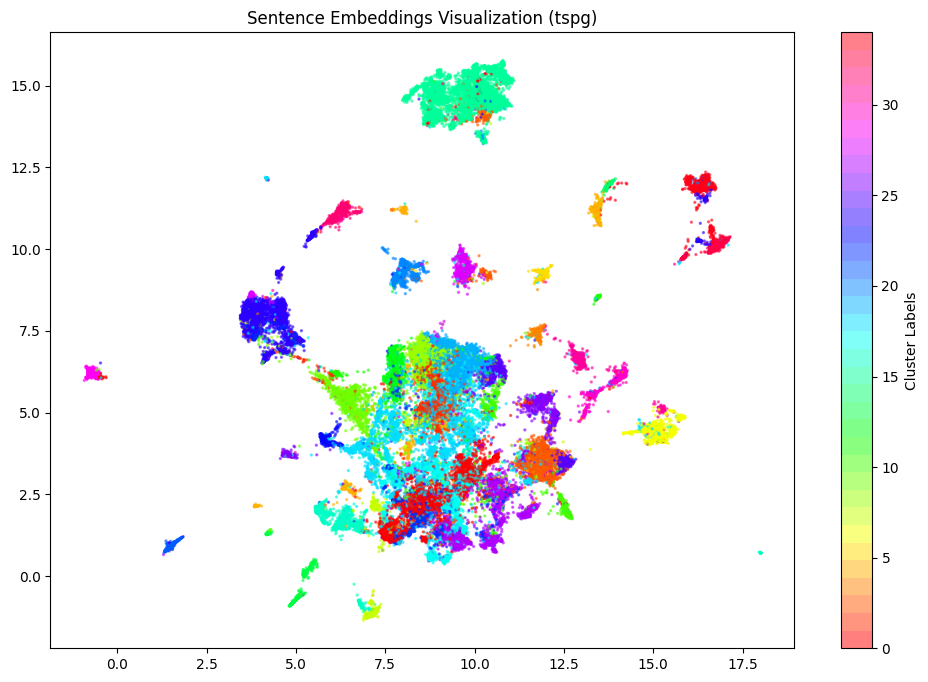

One-hot labels:


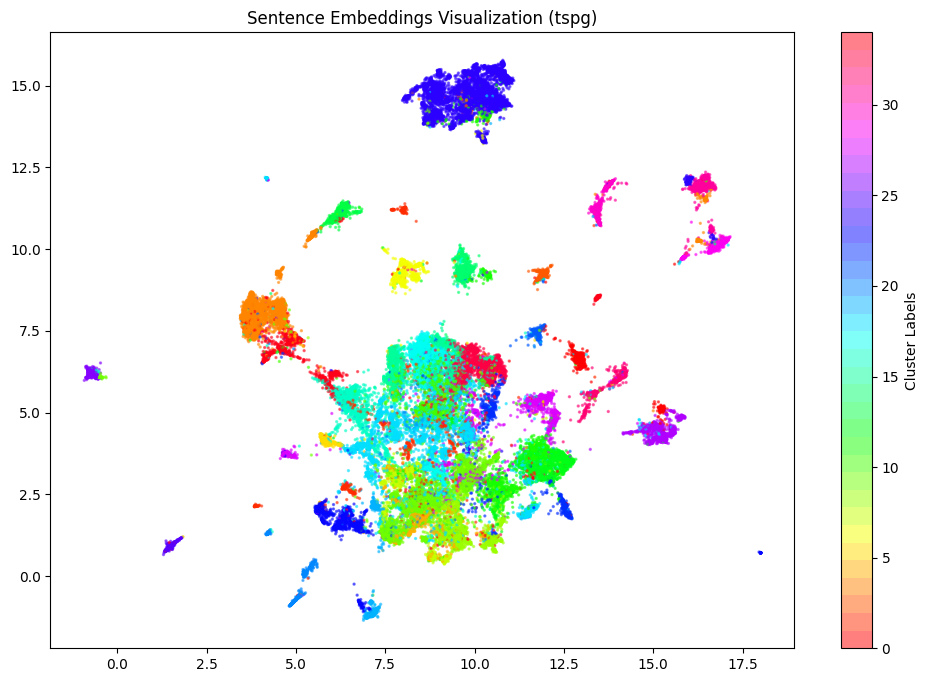

In [10]:
# Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels, clustering_method=None):
    plt.figure(figsize=(12, 8))

    reducer = umap.UMAP(n_components=2, random_state=73, n_neighbors=200, min_dist=0.1, metric='cosine')
    embeddings_2d = reducer.fit_transform(np.array(embeddings))

    cluster_labels = np.array(cluster_labels)

    cmap = plt.get_cmap('hsv', len(set(cluster_labels)))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=cmap, alpha=0.5, s=2)

    plt.colorbar(scatter, label='Cluster Labels')
    plt.title(f"Sentence Embeddings Visualization ({clustering_method})")
    plt.show()

print("Perpendicular labels:")
plot_sentence_embeddings(biased_embeddings_perpendicular, cluster_labels=labels_perpendicular, clustering_method=clustering_method)
print("One-hot labels:")
plot_sentence_embeddings(biased_embeddings_one_hot, cluster_labels=labels_one_hot, clustering_method=clustering_method)

In [11]:
class SubgroupCreator:
    def __init__(self, X_df, target_df, target_value, target_column, file_path):
        self.X_df = X_df
        self.target_df = target_df
        self.target_value = target_value
        self.target_column = target_column
        self.file_path = file_path
        self.tp_dict = {}
        self.fp_dict = {}
        self.TP_dict = {}
        self.FP_dict = {}
        self.WRAcc_dict = {}
        self.Quality_dict = {}
        self.subgroups = {}
        self.total_coverage = 0
        self.subgroup_descriptions = {}

    def evaluate_rule(self, rule_str, covered_indices_set):
        parts = rule_str.split(" AND ")
        mask = pd.Series(True, index=self.X_df.index)

        description = []

        for part in parts:
            feature, operator, value = part.rsplit(maxsplit=2)
            value = float(value)

            if ">" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} = '{category_value}'")
                mask &= self.X_df[feature] > 0.5

            elif "<=" in operator:
                feature_name = feature.rsplit("_", 1)[0]
                category_value = feature.split("_")[-1]
                description.append(f"{feature_name} ≠ '{category_value}'")
                mask &= self.X_df[feature] <= 0.5

        covered_indices = set(self.X_df[mask].index) - covered_indices_set
        covered_indices_set.update(covered_indices)
        covered_targets = self.target_df.loc[list(covered_indices)]

        tp = (covered_targets == self.target_value).sum().item()
        fp = (covered_targets != self.target_value).sum().item()
        TP = (self.target_df == self.target_value).sum().item()
        FP = (self.target_df != self.target_value).sum().item()

        def safe_wracc(tp, fp, TP, FP):
            if (tp + fp) == 0 or (TP + FP) == 0:
                return 0.0
            return ((tp + fp) / (TP + FP)) * ((tp / (tp + fp)) - (TP / (TP + FP)))

        WRAcc = safe_wracc(tp, fp, TP, FP)

        return tp, fp, TP, FP, WRAcc, covered_indices, description

    def try_merge_rules(self, rules_list):
        from collections import defaultdict

        parsed_rules = []
        for rule in rules_list:
            if "No rules" in rule or "Accuracy below" in rule:
                continue
            conditions = sorted(rule.split(" AND "))
            parsed_rules.append((rule, conditions))

        condition_buckets = defaultdict(list)
        for original_rule, conditions in parsed_rules:
            for i in range(len(conditions)):
                key = tuple(conditions[:i] + conditions[i+1:])
                condition_buckets[key].append((original_rule, conditions))

        merged = set()
        final_rules = []

        for shared_conditions, group in condition_buckets.items():
            if len(group) == 2:
                (_, conds1), (_, conds2) = group
                differing = list(set(conds1) ^ set(conds2))
                if len(differing) == 2:
                    feat1 = differing[0].rsplit(" ", 2)[0]
                    feat2 = differing[1].rsplit(" ", 2)[0]
                    if feat1 == feat2:
                        merged_rule = " AND ".join(shared_conditions)
                        final_rules.append(merged_rule)
                        merged.update([group[0][0], group[1][0]])
            else:
                for rule, _ in group:
                    if rule not in merged:
                        final_rules.append(rule)

        untouched_rules = [r for r, _ in parsed_rules if r not in merged]
        final_rules.extend(untouched_rules)

        return list(set(final_rules))


    def evaluate_all_clusters(self, subgroups):
        with open(self.file_path, "w") as f:
            for cluster, rules_list in subgroups.rules_dict.items():
                if cluster not in subgroups.unextractable_clusters:
                    rules_list = self.try_merge_rules(rules_list)
                    covered_indices_set = set()

                    for idx, rule_str in enumerate(rules_list):
                        if "No rules extracted" in rule_str or "Accuracy below threshold" in rule_str:
                            continue

                        letter_index = string.ascii_lowercase[idx]
                        subgroup_label = f"{cluster}.{letter_index}"

                        tp, fp, TP, FP, WRAcc, covered_indices, description = self.evaluate_rule(rule_str, covered_indices_set)

                        self.tp_dict[subgroup_label] = tp
                        self.fp_dict[subgroup_label] = fp
                        self.TP_dict[subgroup_label] = TP
                        self.FP_dict[subgroup_label] = FP
                        self.WRAcc_dict[subgroup_label] = WRAcc
                        self.subgroups[subgroup_label] = covered_indices
                        self.total_coverage += tp + fp

                        description_str = ", ".join(str(item) for item in description)
                        self.Quality_dict[subgroup_label] = Quality_metric(
                            tp=tp,
                            fp=fp,
                            TP=TP,
                            FP=FP,
                            description_length=len(description),
                            description_length_limit=description_length_limit,
                            difference_limit=difference_limit,
                            subgroup_size_limit=subgroup_size_limit,
                        )
                        self.subgroup_descriptions[subgroup_label] = description_str

                        f.write(
                            f"Description: [{description_str}], Target: {target_column} = '{self.target_value}' ; "
                            f"QuMe = {float(self.Quality_dict[subgroup_label]) if self.Quality_dict[subgroup_label] is not None else 0:.8f} ; "
                            f"WRAcc = {float(WRAcc) if WRAcc is not None else 0:.8f} ; "
                            f"tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                        )
            f.write(f"Total coverage: {self.total_coverage / len(self.target_df)}\n")


evaluator_perpendicular = SubgroupCreator(tree_trainer_perpendicular.X_df, target_df, target_value=target_value, target_column=target_column, file_path="results_SDUEBA_perpendicular.txt")
evaluator_perpendicular.evaluate_all_clusters(clusters_perpendicular)
evaluator_one_hot = SubgroupCreator(tree_trainer_one_hot.X_df, target_df, target_value=target_value, target_column=target_column, file_path="results_SDUEBA_one_hot.txt")
evaluator_one_hot.evaluate_all_clusters(clusters_one_hot)

In [12]:
%%time
run_this = False
if run_this:
    !pip install subgroups
    from subgroups.algorithms import BSD
    from subgroups.quality_measures import WRAcc
    from subgroups.quality_measures import WRAccOptimisticEstimate1

    dataset = pd.concat([features_raw, target_df], axis=1).astype(str)
    target = ('readmit_binary', 'Yes')
    print(len(dataset))

    bsd_model = BSD(min_support=0, quality_measure=WRAcc(), optimistic_estimate = WRAccOptimisticEstimate1(), num_subgroups=100, max_depth=2, write_results_in_file = True, file_path = "./results_BSD.txt" )
    bsd_model.fit(dataset, target)


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs


In [13]:
def parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit):
    output_file = "results_BSD_.txt"

    with open(file_path, 'r') as file, open(output_file, 'w') as output:
        for line in file:
            match = re.search(r"(Description: \[.*?\]), Target: (.*?) ; Quality Measure WRAcc = ([\d.-]+) ; tp = (\d+) ; fp = (\d+) ; TP = (\d+) ; FP = (\d+)", line)

            if match:
                description = match.group(1)
                target = match.group(2)
                WRAcc = float(match.group(3))
                tp = int(match.group(4))
                fp = int(match.group(5))
                TP = int(match.group(6))
                FP = int(match.group(7))

                description_text = description[13:-1]
                description_length = description_text.count(',') + 1 if description_text else 1

                quality_score = Quality_metric(tp, fp, TP, FP, description_length, description_length_limit, difference_limit, subgroup_size_limit)

                output_line = f"{description}, Target: {target} ; QuMe = {quality_score:.8f} ; WRAcc = {WRAcc:.8f} ; tp = {tp} ; fp = {fp} ; TP = {TP} ; FP = {FP}\n"
                output.write(output_line)
if run_this:
    file_path = "results_BSD.txt"
    parse_and_compute_quality(file_path, description_length_limit, difference_limit, subgroup_size_limit)

In [14]:
#Overlap ratio
def compute_coverage(filename, quality_measure, k, dataset, print_subgroups=False):
    with open(filename, 'r') as file:
        lines = file.readlines()

    subgroups = []
    instance_coverage = {}

    for line in lines:
        match = re.search(rf"{quality_measure}\s*=\s*([-+]?\d*\.?\d+)\s*;.*tp\s*=\s*(\d+)\s*;\s*fp\s*=\s*(\d+)", line)
        if match:
            quality = float(match.group(1))
            tp = int(match.group(2))
            fp = int(match.group(3))

            desc_match = re.search(r"Description: \[(.*?)\]", line)
            if desc_match:
                description = desc_match.group(1).split(", ")
            else:
                description = []

            mask = pd.Series(True, index=dataset.index)
            for condition in description:
                try:
                    feature, value = condition.split(" = ")
                    value = value.strip("'")

                    if feature not in dataset.columns:
                        continue

                    mask &= dataset[feature] == value
                except ValueError:
                    continue

            covered_instances = set(dataset[mask].index)

            for instance in covered_instances:
                instance_coverage[instance] = instance_coverage.get(instance, 0) + 1

            subgroups.append((quality, covered_instances, description, line.strip()))

    subgroups.sort(reverse=True, key=lambda x: x[0])
    top_k_subgroups = subgroups[:k]

    covered_instances = set()
    filtered_instance_coverage = {}

    for _, instance_ids, _, _ in top_k_subgroups:
        covered_instances.update(instance_ids)
        for instance in instance_ids:
            filtered_instance_coverage[instance] = filtered_instance_coverage.get(instance, 0) + 1

    coverage = len(covered_instances) / len(dataset) if len(dataset) else 0
    overlapping_instances = sum(1 for count in filtered_instance_coverage.values() if count > 1)
    overlap_ratio = overlapping_instances / len(covered_instances) if covered_instances else 0

    if print_subgroups:
        print("Top-k subgroups:")
        for _, _, _, subgroup in top_k_subgroups:
            print(subgroup)

    return coverage, overlap_ratio


print("SDUEBA model (perpendicular embedding bias):")
coverage_SDUEBA, overlap_SDUEBA = compute_coverage('results_SDUEBA_perpendicular.txt', 'QuMe', n_clusters, features_raw, True)
print(f"Coverage: {coverage_SDUEBA}, Overlap Ratio: {overlap_SDUEBA}")

print("SDUEBA model (one-hot embedding bias):")
coverage_SDUEBA, overlap_SDUEBA = compute_coverage('results_SDUEBA_one_hot.txt', 'QuMe', n_clusters, features_raw, True)
print(f"Coverage: {coverage_SDUEBA}, Overlap Ratio: {overlap_SDUEBA}")
if run_this:
    print("BSD model:")
    coverage_BSD, overlap_BSD = compute_coverage('results_BSD_.txt', 'QuMe', n_clusters, features_raw, True)
    print(f"Coverage: {coverage_BSD}, Overlap Ratio: {overlap_BSD}")

SDUEBA model (perpendicular embedding bias):
Top-k subgroups:
Description: [medical_specialty = 'ObstetricsandGynecology'], Target: readmit_binary = 'Yes' ; QuMe = 0.24783634 ; WRAcc = -0.00161708 ; tp = 70 ; fp = 262 ; TP = 23339 ; FP = 27544
Description: [primary_diag_desc = 'Displacement of cervical intervertebral disc without myelopathy'], Target: readmit_binary = 'Yes' ; QuMe = 0.19677495 ; WRAcc = -0.00146180 ; tp = 99 ; fp = 279 ; TP = 23339 ; FP = 27544
Description: [primary_diag_desc = 'Malignant neoplasm of trachea'], Target: readmit_binary = 'Yes' ; QuMe = 0.15062284 ; WRAcc = -0.00062460 ; tp = 65 ; fp = 146 ; TP = 23339 ; FP = 27544
Description: [primary_diag_desc = 'Iron deficiency anemia secondary to blood loss (chronic)'], Target: readmit_binary = 'Yes' ; QuMe = 0.13020917 ; WRAcc = 0.00046062 ; tp = 106 ; fp = 74 ; TP = 23339 ; FP = 27544
Description: [diag_2_desc = 'Hypertensive chronic kidney disease, malignant, with chronic kidney disease stage I through stage IV, o